In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Line detection

Choose 2 points to sample random

In [2]:
def RandomSample(r,c,n): # r: array of row points, c: array of column points, n: number of points to sample random
    totalPoints = len(r)
    idx = np.random.permutation(np.arange(totalPoints))
    idx = idx[:n] # pick first n indecies
    r2,c2 = [],[] # initialize 2 empty array
    for i in range(len(idx)):
        r2.append(r[idx[i]])
        c2.append(c[idx[i]])
    return r2,c2

In [3]:
r = np.arange(10)
c = np.arange(10)[::-1] # reverse order

In [4]:
print(r)

[0 1 2 3 4 5 6 7 8 9]


In [5]:
print(c)

[9 8 7 6 5 4 3 2 1 0]


In [6]:
r2,c2 = RandomSample(r,c,2)
print(r2,c2)

[2, 0] [7, 9]


Fitting lines with 2 points

In [7]:
def FitLine(r1,c1,r2,c2): # r = x : rows , c = y : columns, 1: point1, 2: point2
    p = np.array([1,1])
    A = np.array([[r1,1],[r2,1]])
    q = np.array([[c1],[c2]])
    if np.linalg.matrix_rank(A) == 2: # compute matrix rank
        p = np.linalg.inv(A).dot(q)
    a, b = p[0], p[1]
    return a,b

In [8]:
a,b = FitLine(r2[0],c2[0],r2[1],c2[1])
print(a,b)

[-1.] [9.]


Score Consistency

In [9]:
def getConsistencyScore(r,c,th,a,b):
    score = 0
    for i in range(len(r)):
        squaredError = (a*r[i]+b - c[i])**2
        if squaredError < th:
            score += 1
    return score

General Function

In [10]:
def RANSACLine(E):
    E = E>0
    idx = np.argwhere(E)
    r , c = idx[:,0] , idx[:,1]
    best_a , best_b = 0 , 0
    maxScore = -1
    numIter = 1000
    for iter in range(numIter):
        r2,c2 = RandomSample(r,c,2)
        a,b = FitLine(r2[0],c2[0],r2[1],c2[1])
        score = getConsistencyScore(r,c,2,a,b)
        if score > maxScore:
            maxScore = score
            best_a , best_b = a , b
    return best_a,best_b

In [11]:
E = plt.imread(r'E.png')

In [12]:
E.shape

(499, 1153, 4)

In [13]:
E = E[:,:,0]

(-0.5, 1152.5, 498.5, -0.5)

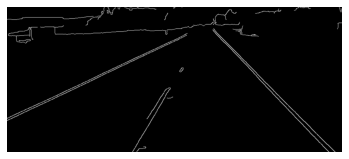

In [14]:
plt.imshow(E,cmap='gray')
plt.axis('off')

In [15]:
best_a, best_b = RANSACLine(E)
best_a, best_b

(array([0.98543689]), array([635.2184466]))

In [16]:
def getExtents(a,b,numRows,numCols):
    r1 = int(0)
    c1 = int(a*r1+b) # (r1,c1) is 1st point
    r2 = int(numRows-1)
    c2 = int(a*r2+b) # (r2,c2) is last point
    return (c1,r1),(c2,r2)

In [17]:
s,e = getExtents(best_a,best_b,E.shape[0],E.shape[1])

In [18]:
s,e # s: starting point, e: ending point

((635, 0), (1125, 498))

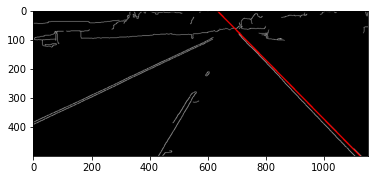

In [19]:
E2 = np.zeros((E.shape[0],E.shape[1],3),dtype=np.uint8)
E3 = np.array(255*E,dtype = np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.line(E2,s,e,(0,0,255),3)
plt.imshow(I[:,:,::-1])

## Circle Detection

Phương pháp viết phương trình đường tròn đi qua 3 điểm:</br>
    Bước 1: Gọi phương trình đường tròn là (C): x^2 + y^2 - 2ax - 2by + c = 0 (E) ( với điều kiện a2 + b2 - c > 0).</br>
    Bước 2: Do điểm A, B và C thuộc đường tròn nên thay tọa độ điểm A, B và C vào (E) ta được phương trình ba phương trình ẩn.</br>
     Bước 3: giải hệ phương trình ba ẩn ta được phương trình đường tròn.</br>

In [20]:
def FitCircle(x1,y1,x2,y2,x3,y3):
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c) 
    px = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    py = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s 
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return px,py,r

In [21]:
def getConsistencyScore_circle(r,c,th,center_r,center_c,radius):
    score = 0
    for i in range(len(r)):
        diff = ((r[i]-center_r)**2 + (c[i]-center_c)**2 - radius**2)**2
        if diff < th:
            score += 1
    return score

In [22]:
def RANSACCircle(E):
    E = E>0
    idx = np.argwhere(E)
    r , c = idx[:,0] , idx[:,1]
    best_cr , best_cc , best_d = 0 , 0 , 0
    maxScore = -1
    numIter = 2000
    for iter in range(numIter):
        r2,c2 = RandomSample(r,c,3)
        center_r,center_c,radius = FitCircle(r2[0],c2[0],r2[1],c2[1],r2[2],c2[2])
        score = getConsistencyScore_circle(r,c,3,center_r,center_c,radius)
        if score > maxScore:
            maxScore = score
            best_cr , best_cc , best_d = center_r , center_c , radius
    return best_cr , best_cc , best_d

In [23]:
image = cv2.imread(r'Ec.png',cv2.IMREAD_GRAYSCALE)

(-0.5, 149.5, 137.5, -0.5)

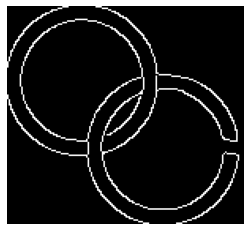

In [24]:
plt.imshow(image,cmap='gray')
plt.axis('off')

In [25]:
image.shape

(138, 150)

In [26]:
image = image>100

In [27]:
x,y,r = RANSACCircle(image)

In [28]:
print(x,y,r)

47.0 47.98571428571429 47.42964929928391


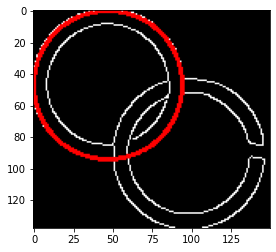

In [29]:
E2 = np.zeros((image.shape[0],image.shape[1],3),dtype=np.uint8)
E3 = np.array(255*image,dtype = np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.circle(E2,(int(y),int(x)),int(r),(0,0,255),2)
plt.imshow(I[:,:,::-1])